## Apply the battery to our data and calculate the cost with and without battery (and logic)

### Ready the dataset

In [1]:
# Load peak hour price data and meter-id data
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt

df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

# Load json file hour_lookup_price.json
with open('data/hour_lookup_price_dict.json') as json_file:
    hour_lookup_price = json.load(json_file)


In [ ]:
print(df_prod.columns)

In [2]:
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [3]:
series_prod = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3", "prod", start="2016-09-04 22:00:00+00:00", end = "2019-05-14 21:00:00+00:00")
series_cons = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3", "cons", start="2016-09-04 22:00:00+00:00", end = "2019-05-14 21:00:00+00:00")

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
Filtering on start and end:  2016-09-04 22:00:00+00:00 2019-05-14 21:00:00+00:00
Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
Filtering on start and end:  2016-09-04 22:00:00+00:00 2019-05-14 21:00:00+00:00


In [4]:
# Merge series
series_merge = pd.merge(series_prod, series_cons, how="outer", left_index=True, right_index=True)
# Rename num_kwh_normalized_x and num_kwh_normalized_y
series_merge.columns = ["num_kwh_prod", "num_kwh_cons"]

# Add column called power_yield with the difference between prod and cons
series_merge["power_yield"] = series_merge["num_kwh_prod"] - series_merge["num_kwh_cons"]
# add column current index as timeslot and reset index
series_merge["timeslot"] = series_merge.index
series_merge = series_merge.reset_index(drop=True)

print(series_merge.head())

   num_kwh_prod  num_kwh_cons  power_yield                  timeslot
0           0.0           0.0          0.0 2016-09-04 22:00:00+00:00
1           0.0           2.0         -2.0 2016-09-04 23:00:00+00:00
2           0.0           1.0         -1.0 2016-09-05 00:00:00+00:00
3           0.0           1.0         -1.0 2016-09-05 01:00:00+00:00
4           0.0           1.0         -1.0 2016-09-05 02:00:00+00:00


## Calculate Cost without battery

In [17]:
# Add column with the price based on the power_yield
def get_price(power_yield, hour):
    return -power_yield * hour_lookup_price[str(hour)]

series_no_battery = series_merge.copy()

# Apply function to dataframe and add column
series_no_battery["price"] = series_no_battery.apply(lambda row: get_price(row["power_yield"], row["timeslot"].hour), axis=1)


Without battery cost

In [18]:
start, end = series_no_battery["timeslot"].iloc[0], series_no_battery["timeslot"].iloc[-1]
print(f"Cost for period: {start} to {end} is: ", round(series_no_battery["price"].sum(), 0), " NOK without VAT")
num_wh_total = series_no_battery["power_yield"].sum() // 1
print(f"Number of kwh used: {-num_wh_total}")
print(f"Installation size: {df_prod['num_panels'].iloc[0]} panels")

Cost for period: 2016-09-04 22:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  56883.0  NOK without VAT
Number of kwh used: 76590.0
Installation size: 41.0 panels


## Calculate Cost with battery without logic

In [19]:
# Initialise battery
from battery import Battery
battery = Battery()
series_battery = series_merge.copy()
print(series_battery.head())

   num_kwh_prod  num_kwh_cons  power_yield                  timeslot
0           0.0           0.0          0.0 2016-09-04 22:00:00+00:00
1           0.0           2.0         -2.0 2016-09-04 23:00:00+00:00
2           0.0           1.0         -1.0 2016-09-05 00:00:00+00:00
3           0.0           1.0         -1.0 2016-09-05 01:00:00+00:00
4           0.0           1.0         -1.0 2016-09-05 02:00:00+00:00


In [20]:
# Def function to apply battery to dataframe
def logic(power_yield):
    # If surplus - charge battery
    if power_yield > 0:
       battery.charge(power_yield)

    # If deficit - discharge battery
    elif power_yield < 0:
        battery.discharge(power_yield)
    
    # If power_yield is 0 - do nothing
    else:
        pass

    # Return battery capacity
    return battery.get_current_capacity()

# Add column with battery capacity
series_battery["battery_capacity"] = series_battery.apply(lambda row: logic(row["power_yield"]), axis=1)

In [21]:
battery = Battery()
# Def function to apply battery to dataframe
def logic(power_yield):
    # If surplus - charge battery
    if power_yield >= 0:
       battery.charge(power_yield)

    # If deficit - discharge battery
    elif power_yield < 0:
        battery.discharge(power_yield)

    # Return battery capacity
    return battery.get_over_under_charge()

series_battery["beyond_battery_capacity"] = series_battery.apply(lambda row: logic(row["power_yield"]), axis=1)

In [22]:
print(series_battery.head())

   num_kwh_prod  num_kwh_cons  power_yield                  timeslot  \
0           0.0           0.0          0.0 2016-09-04 22:00:00+00:00   
1           0.0           2.0         -2.0 2016-09-04 23:00:00+00:00   
2           0.0           1.0         -1.0 2016-09-05 00:00:00+00:00   
3           0.0           1.0         -1.0 2016-09-05 01:00:00+00:00   
4           0.0           1.0         -1.0 2016-09-05 02:00:00+00:00   

   battery_capacity  beyond_battery_capacity  
0               0.0                      0.0  
1               0.0                     -2.0  
2               0.0                     -1.0  
3               0.0                     -1.0  
4               0.0                     -1.0  


In [23]:
def moving_average(timeseries, window):
    """Calculate the moving average of a timeseries.

    Args:
        timeseries (pd.Series): timeseries
        window (int): Window size

    Returns:
        pd.Series: Smoothened timeseries
    """
    return timeseries.rolling(window=window, center=True).mean()

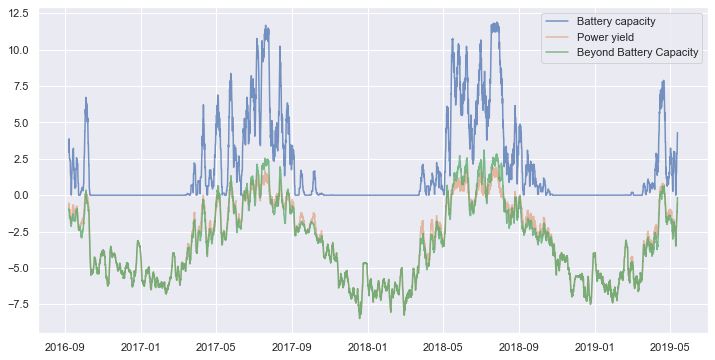

In [14]:
# plot battery capacity and power yield in same plot with plotly
import seaborn as sns
sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery["timeslot"], moving_average(series_battery["battery_capacity"], 80), label="Battery capacity", alpha=0.75)
ax.plot(series_battery["timeslot"], moving_average(series_battery["power_yield"], 80), label="Power yield", alpha=0.5)
ax.plot(series_battery["timeslot"], moving_average(series_battery["beyond_battery_capacity"], 80), label="Beyond Battery Capacity", alpha=0.75)
ax.legend()
plt.show()

In [28]:
def get_price_battery(demand, hour):
    return -demand * hour_lookup_price[str(hour)]

series_battery["price"] = series_battery.apply(lambda row: get_price_battery(row["beyond_battery_capacity"], row["timeslot"].hour), axis=1)

### Price with battery without logic

In [30]:
start, end = series_battery["timeslot"].iloc[0], series_battery["timeslot"].iloc[-1]
print(f"Cost for period: {start} to {end} is: ", round(series_battery["price"].sum(), 0), " NOK without VAT")
num_wh_total = series_battery["beyond_battery_capacity"].sum() // 1
print(f"Number of kwh used: {-num_wh_total}")

Cost for period: 2016-09-04 22:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  57390.0  NOK without VAT
Number of kwh used: 77193.0


## Estimate cost with battery and with logic

if next hour's estimated cost is higher than our current - we wait discharging our battery

In [ ]:
# Initialise battery
from battery import Battery
battery = Battery()
series_battery_logic = series_merge.copy()
print(series_battery_logic.head())

We calculate the battery capacity just in case we need it

In [ ]:
# Def function to apply battery to dataframe
def logic(power_yield):
    # If surplus - charge battery
    if power_yield > 0:
       battery.charge(power_yield)

    # If deficit - discharge battery
    elif power_yield < 0:
        battery.discharge(power_yield)
    
    # If power_yield is 0 - do nothing
    else:
        pass

    # Return battery capacity
    return battery.get_current_capacity()

# Add column with battery capacity
series_battery_logic["battery_capacity"] = series_battery_logic.apply(lambda row: logic(row["power_yield"]), axis=1)

In [ ]:
battery = Battery()
# Def function to apply battery to dataframe
def logic(power_yield):
    # If surplus - charge battery
    if power_yield >= 0:
       battery.charge(power_yield)

    # If deficit - discharge battery
    elif power_yield < 0:
        battery.discharge(power_yield)

    # Return battery capacity
    return battery.get_over_under_charge()

series_battery_logic["beyond_battery_capacity"] = series_battery_logic.apply(lambda row: logic(row["power_yield"]), axis=1)

In [ ]:
print(series_battery_logic.head())

In [ ]:
def logic(battery_now, now_power_yield, next_power_yield, hour):
    """If the price of the next hour is higher than the price of the current hour,
    the battery will not be discharged

    Args:
        battery_now (object): The current battery object
        now_power_yield (float): _description_
        next_power_yield (float): _description_
        hour (int): _description_

    Returns:
        None
    """
    
    if now_power_yield > 0:
       battery.charge(now_power_yield)
       return battery.get_over_under_charge()
    
    # Load battery with current capacity
    current_over_under = battery_now.get_over_under_charge()
    current_battery_capacity = battery_now.get_current_capacity()
    battery_next = Battery(current_battery_capacity, current_over_under)
    battery_now = Battery(current_battery_capacity, current_over_under)

    # Simulate next hour
    if next_power_yield > 0:
       battery_next.charge(next_power_yield)

    elif next_power_yield < 0:
        battery_next.discharge(next_power_yield)

    # Calculate the battery for the current hour
    if now_power_yield > 0:
       battery_now.charge(now_power_yield)

    elif now_power_yield < 0:
        battery_now.discharge(now_power_yield)

    now_battery_over_under_charge = battery_now.get_over_under_charge()

    # We now have a battery for the next hour as if we did not use it for the current hour
    next_battery_over_under_charge = battery_next.get_over_under_charge()

    # Price if we need to pay now
    price_now = now_battery_over_under_charge * hour_lookup_price[str(hour)]
    # Price if we dont dicharged now
    next_hour = hour + 1 if hour < 23 else 0
    price_next = next_battery_over_under_charge * hour_lookup_price[str(next_hour)]

    if price_now >= price_next:
        battery.discharge(now_power_yield)
    
    else:
        # We buy all the power we need right now
        battery.over_under_charge = now_power_yield

    return battery.get_over_under_charge()

In [ ]:
def new_logic():
    """We make decisiions on an hourly interval - based on a 1 day prediction ahead (24 units)
    """

In [ ]:
# Apply battery logic to dataframe where next_power_yield is the power_yield of the next row
battery = Battery()
for index, row in series_battery_logic.iterrows():
    # If next index is last index, we dont have a next row
    if index == series_battery_logic.shape[0] - 1:
        break

    series_battery_logic.loc[index, "beyond_battery_capacity"] = logic(battery, row["power_yield"], series_battery_logic.loc[index+1, "power_yield"], row["timeslot"].hour)

In [ ]:
print(series_battery_logic.isnull().sum())

In [ ]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery_logic["timeslot"], series_battery_logic["battery_capacity"] / 10, label="Battery capacity")
ax.plot(series_battery_logic["timeslot"], series_battery_logic["power_yield"], label="Power yield")
ax.plot(series_battery_logic["timeslot"], series_battery_logic["beyond_battery_capacity"], label="Beyond Battery Capacity")
ax.legend()
plt.show()

In [ ]:
# Calculate cost for battery
def get_price_battery(demand, hour):
    return -demand * hour_lookup_price[str(hour)]

series_battery_logic["price"] = series_battery_logic.apply(lambda row: get_price_battery(row["beyond_battery_capacity"], row["timeslot"].hour), axis=1)

In [ ]:
start, end = series_battery_logic["timeslot"].iloc[0], series_battery_logic["timeslot"].iloc[-1]
print(f"Cost for period: {start} to {end} is: ", round(series_battery_logic["price"].sum(), 0), " NOK without VAT")